# Wave Detection algorithms

## 0 : Introduction

The pupose of this notebook is to review the different methods used in the litterature to detect traveling waves in datasets. It is the prelimimary step before calculating all the waves characteristics (speed, span, duration, tajectory,...). The algorithm must be robust as VSD data is very noisy.

### Importation

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.colors as colors
from matplotlib import cm
import scipy.ndimage as img
import scipy.signal as signal
import scipy.stats as stat
import numpy as np

### Data loading

In [2]:
bks_blank_path = r'/media/mathis/Data/Mathis/blank_ziggy_210908.npy'
bks_evoked_path = r'/media/mathis/Data/Mathis/gaussian_pos4_ziggy_210908.npy'

awak_pattern_path = r'/media/mathis/Data/Mathis/awake_annoted.png'

In [3]:
Bks_blank = np.load(bks_blank_path)
Bks_evoked = np.load(bks_evoked_path)

Vasc_pattern = plt.imread(awak_pattern_path)

### Trial & parameters definition

To test the diferent algorithms, let's pick a trial with a pretty wave in it

In [4]:
Trial = np.copy(Bks_evoked[8])
nan_mask = np.isnan(Trial)
Trial[nan_mask]=np.nanmean(Trial)
Nt, Nx, Ny = Trial.shape

In [5]:
fs=100 #Hz
pixel_spacing = 0.0566 #mm
time = np.array([i/fs for i in range(Nt)])

### Masking

In [6]:
def circular_mask(shape, center, radius):
    Y, X = np.ogrid[:shape[0], :shape[1]]
    return ((X - center[0]) ** 2 + (Y - center[1]) ** 2) <= radius ** 2

mask_boolean = circular_mask(Trial.shape[1:], center=(220,190), radius=175)
Trial*=mask_boolean

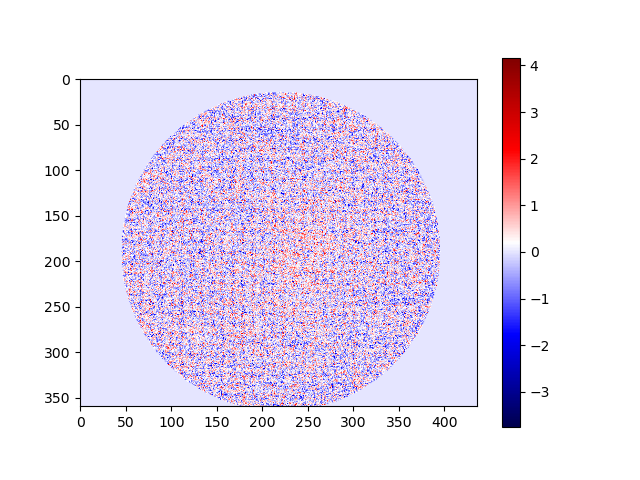

In [7]:
plt.figure()
plt.imshow(Trial[24], cmap='seismic')
plt.colorbar()
plt.show()

## 1 : Threshold

A common approach is to consider that a propagating wave is the propagation of an increased value over pixels, and so that detecting pixels with an high value with a threshold will help to isolate the wave from the whole field. So let's choose a specific threshold and give a zero value for all pixels above.

In [12]:
threshold=80 #%
critical_value=np.percentile(Trial, threshold)
print(critical_value)

0.4518097632380235


In [10]:
histo_trial, edges = np.histogram(Trial[Trial!=0], bins=100, density=True)
globmin, globmax = np.min(Trial), np.max(Trial)

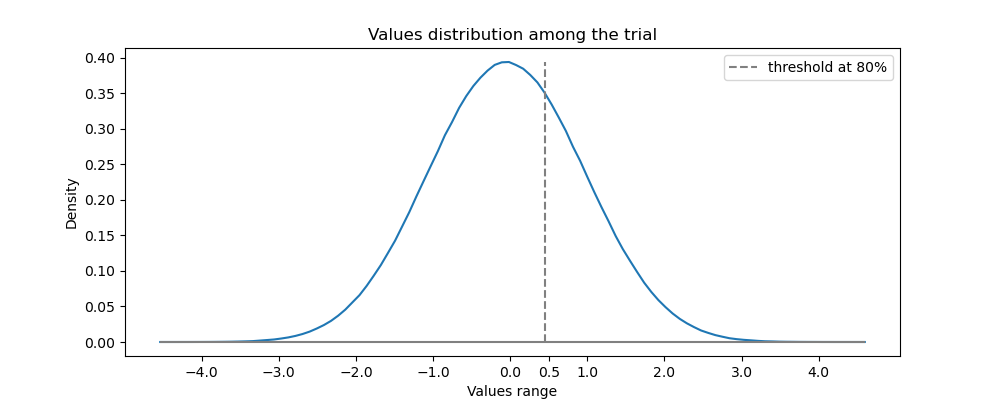

In [21]:
plt.figure(figsize=(10,4))
plt.title('Values distribution among the trial')
plt.xlabel('Values range')
plt.ylabel('Density')
plt.plot(edges[:-1],histo_trial)
plt.hlines(0, edges[0], edges[-2], 'gray')
plt.vlines(critical_value, 0, np.max(histo_trial), color='gray', linestyle='dashed', label='threshold at '+str(threshold)+'%')
plt.xticks(list(range(-4,5))+[np.round(critical_value,1)])
plt.legend()
plt.show()

In [22]:
Trial_thresh = np.copy(Trial)
Trial_thresh[Trial_thresh<critical_value]=0

## 2 : Image processing

To remove "salt & pepper" noise from the thresholded data and for a purpose of visualisation, a spatial filtering could be useful.

In [23]:
Sample = np.copy(Trial_thresh[23])
Smoothed_median=img.median_filter(Sample,size=(3,3), mode='constant')
Smoothed=img.gaussian_filter(Smoothed_median, sigma=10, mode='constant')


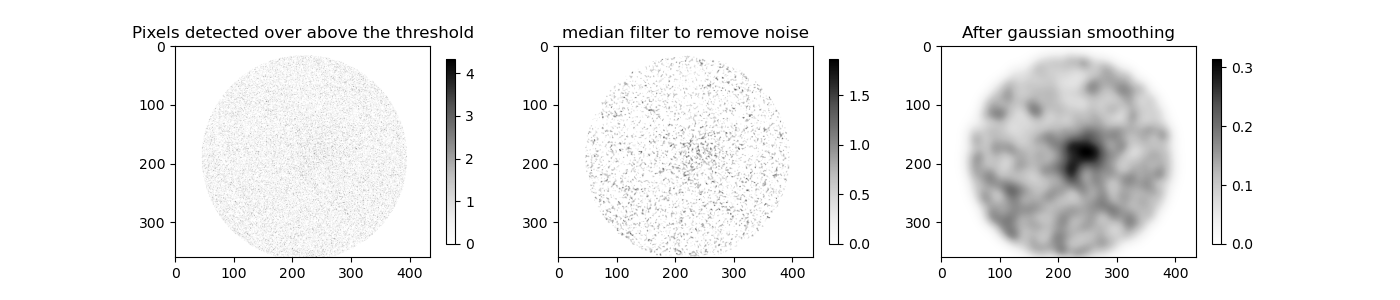

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,3))

norm1 = cm.colors.Normalize(vmax=np.max(Sample), vmin=0)
norm2 = cm.colors.Normalize(vmax=np.max(Smoothed_median), vmin=0)
norm3 = cm.colors.Normalize(vmax=np.max(Smoothed), vmin=0)

raw = ax1.imshow(Sample, cmap='Greys', norm=norm1)
ax1.set_title('Pixels detected over above the threshold')
fig.colorbar(raw, ax=ax1, shrink=.8)

smooth_median = ax2.imshow(Smoothed_median, cmap='Greys', norm=norm2)
ax2.set_title('median filter to remove noise')
fig.colorbar(smooth_median, ax=ax2, shrink=.8)

smooth = ax3.imshow(Smoothed, cmap='Greys', norm=norm3)
ax3.set_title('After gaussian smoothing')
fig.colorbar(smooth, ax=ax3, shrink=.8)

plt.show()

## Center of mass analysis

In [98]:
def center_of_mass(Field):
    Lx,Ly = Field.shape
    total_mass = Field.sum()
    meshx, meshy = np.meshgrid(np.arange(Ly), np.arange(Lx))
    return np.array([ (meshx*Field).sum()/total_mass, (meshy*Field).sum()/total_mass  ])

In [ ]:
def median_center(Field):
    Lx,Ly = Field.shape
    meshx, meshy = np.meshgrid(np.arange(Ly), np.arange(Lx))
    return np.array([  (meshx*Field) ])

In [99]:
xcom, ycom = center_of_mass(Sample)
x2, y2 = center_of_mass(Smoothed)

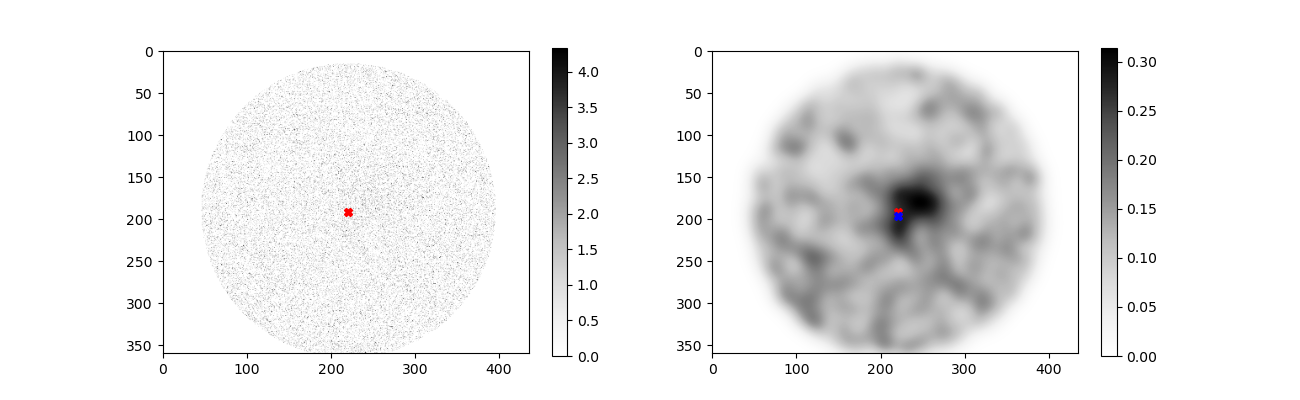

In [100]:
fig, axs = plt.subplots(1,2, figsize=(13,4))

u1 = axs[0].imshow(Sample, cmap='Greys')
u2 = axs[1].imshow(Smoothed, cmap='Greys')

axs[0].plot(xcom, ycom, color='r',marker='X')
axs[1].plot(xcom, ycom, color='r',marker='X')
axs[1].plot(x2, y2, color='b',marker='X')

fig.colorbar(u1, ax=axs[0])
fig.colorbar(u2, ax=axs[1])

plt.show()

In [101]:
Point=[]
Blurred=[]
for t in range(Nt):
    M = center_of_mass(Trial[t])
    filtmed=img.median_filter(Trial[t],size=(3,3), mode='constant')
    filt=img.gaussian_filter(filtmed, sigma=10, mode='constant')
    M_filt = center_of_mass(filt)
    Point.append(M)
    Blurred.append(M_filt)

Point=np.array(Point)
Blurred=np.array(Blurred)

Dist = np.linalg.norm(np.diff(Point,axis=0), axis=1)
Dist_filt = np.linalg.norm(np.diff(Blurred,axis=0), axis=1)

Speed = Dist*fs*pixel_spacing/1000 #m/s
Speed_filt = Dist_filt*fs*pixel_spacing/1000 #m/s

Theta = np.arctan2(np.diff(Point[:,1]), np.diff(Point[:,0]))
Theta_filt = np.arctan2(np.diff(Blurred[:,1]), np.diff(Blurred[:,0]))

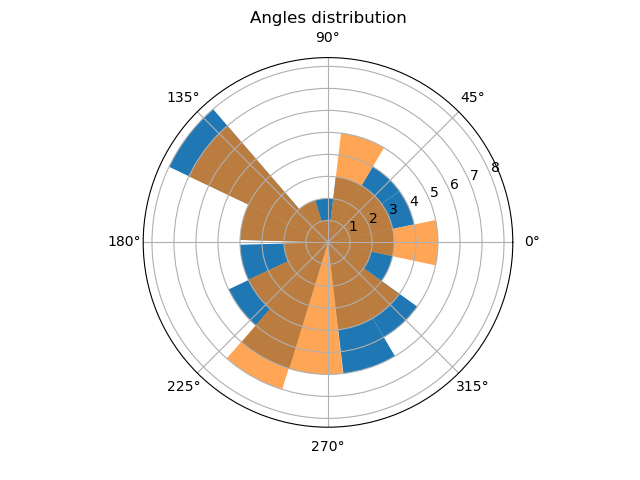

In [102]:
plt.figure()
ax1 = plt.subplot(111, projection='polar')
ax1.set_title('Angles distribution')
ax1.hist(Theta, bins=15)
ax1.hist(Theta_filt, bins=15, alpha=.7)
plt.show()

In [ ]:
M_filt[k,0]

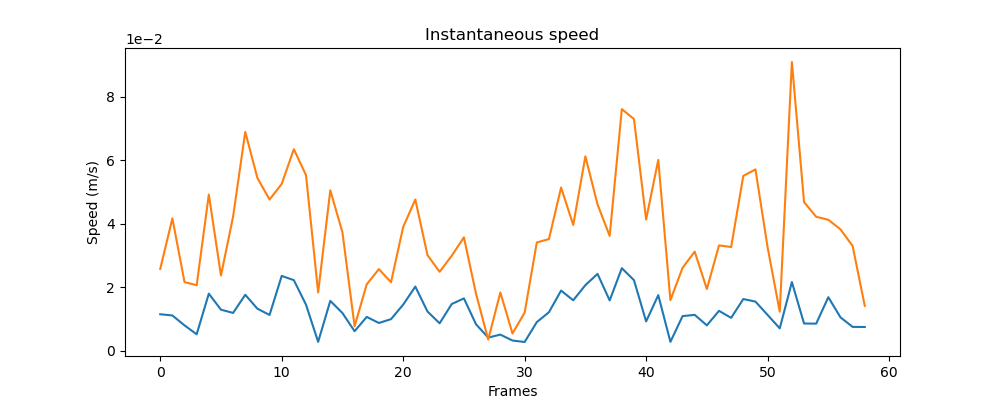

In [104]:
plt.figure(figsize=(10,4))
plt.title('Instantaneous speed')
plt.xlabel('Frames')
plt.ylabel('Speed (m/s)')
plt.plot(Speed)
plt.plot(Speed_filt)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,-2))
plt.show()

## Phase analysis

In [105]:
Z=signal.hilbert(Trial, axis=0)
Phase=np.angle(Z)

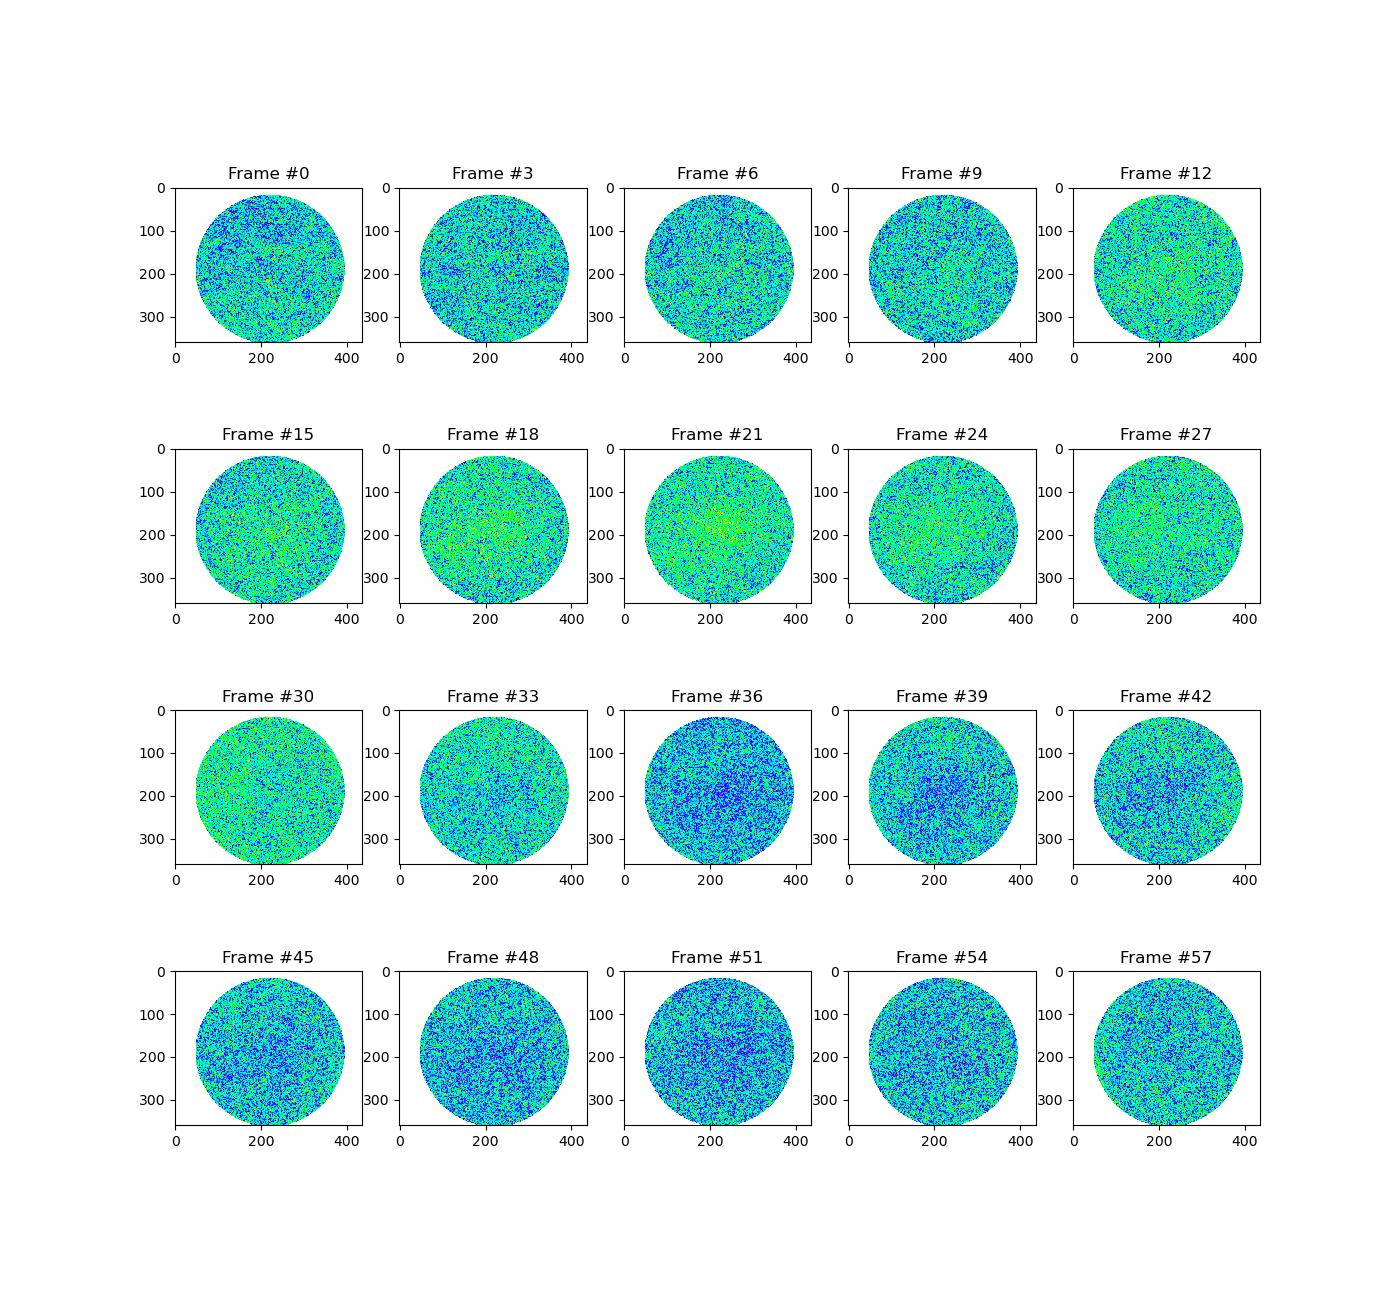

In [106]:
fig, axs = plt.subplots(4,5, figsize=(14,13))
for k in range(60):
    if k%3==0:
        ind=k//3
        Pk = np.copy(Phase[k])
        Pk[~mask_boolean]=np.nan
        axs[ind//5, ind%5].imshow(Pk, cmap='hsv')
        axs[ind//5, ind%5].set_title("Frame #"+str(k))

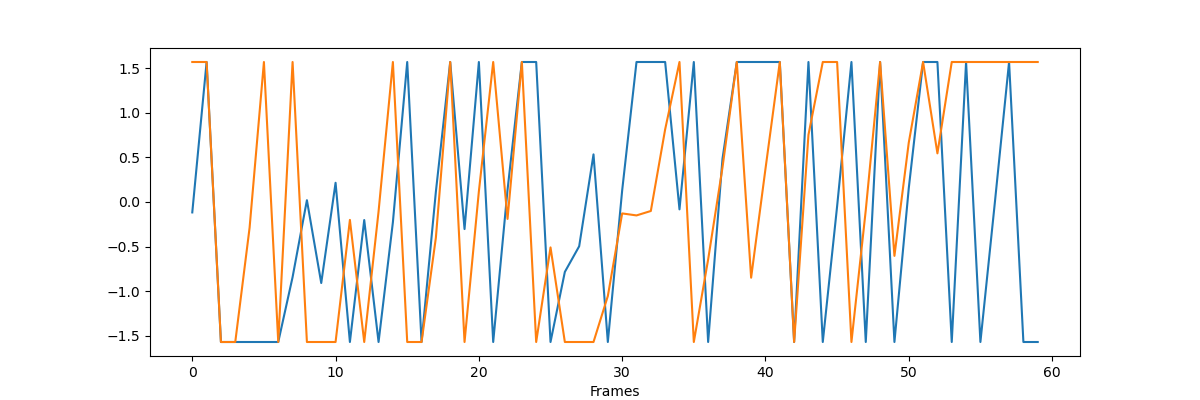

In [107]:
plt.figure(figsize=(12,4))
plt.xlabel('Frames')
plt.plot(Phase[:,220,180])
plt.plot(Phase[:,220,181])
plt.show()

In [108]:
grad = np.array(np.gradient(Phase, axis=(1,2)))/pixel_spacing*1000
mean_grad = np.mean(grad, axis=(2,3))

In [109]:
norm_mean_grad = np.linalg.norm(mean_grad)
mean_norm_grad = np.mean(np.linalg.norm(grad,axis=0), axis=(1,2))

In [110]:
PGD = norm_mean_grad/mean_norm_grad

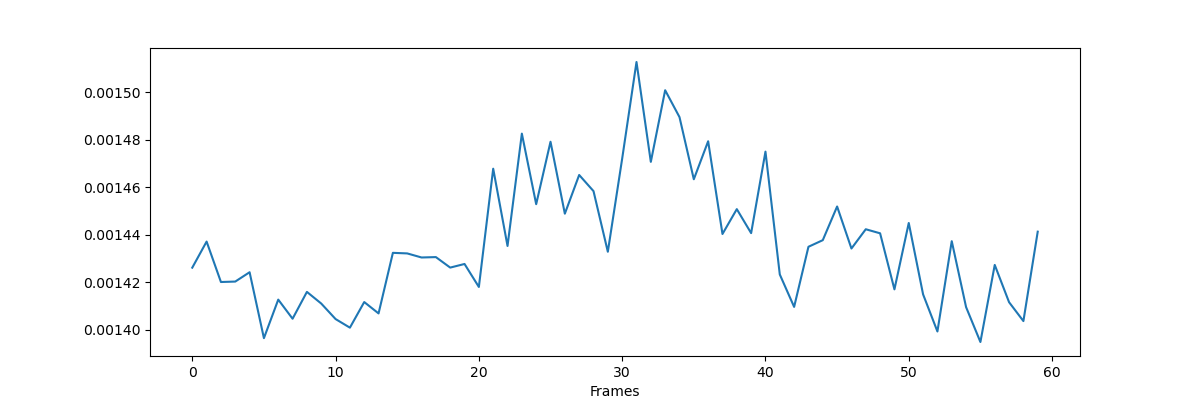

In [111]:
plt.figure(figsize=(12,4))
plt.xlabel('Frames')
plt.plot(PGD)
plt.show()

In [112]:
instant_freq = np.angle(np.roll(Z,-1,axis=0)*np.conj(Z))*fs
mean_instant_freq = np.mean(instant_freq, axis=(1,2))

In [113]:
phase_speed = mean_instant_freq/mean_norm_grad

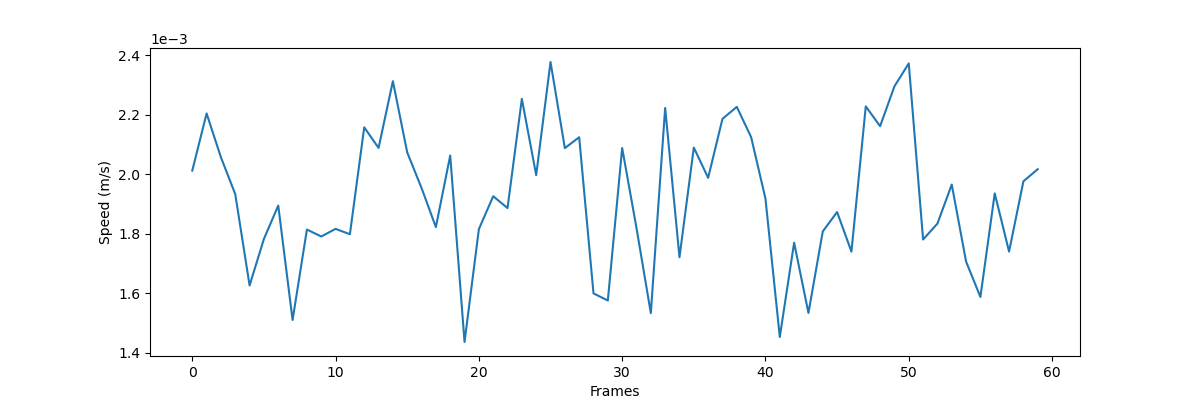

In [116]:
plt.figure(figsize=(12,4))
plt.xlabel('Frames')
plt.plot(phase_speed)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,-2))
plt.ylabel('Speed (m/s)')
plt.show()